
### Load packages

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dateutil.parser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import matplotlib
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from datetime import date
import os
from scipy import stats
from scipy.stats import norm, skew #for some statistics
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')



from google.colab import drive
drive.mount('/content/gdrive')







### Load data

In [2]:
data = pd.read_csv('data.csv')

geoloc = pd.read_csv('address.csv')

#test = pd.read_csv('house_price_data/test.csv')
#print ("Data is loaded!")
geoloc.head()
geoloc = geoloc.drop(columns = ['accuracy','Unnamed: 0', 'google_place_id','formatted_address', 'input_string', 'number_of_results', 'status', 'type'])
data=data.drop(columns =['Unnamed: 0'])

In [3]:
data = pd.concat([data, geoloc], axis=1)


In [4]:
print ("Train: ",data.shape[0],"sales, and ",data.shape[1],"features")
#print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

data.head()

Train:  10052 sales, and  64 features


,Address,MLS No,Penthouse,Renovation,Cats,Dogs,Ocean View,City View,Mountain View,Park View,...,Undivided Interest,List Price,Sold Price,Sold Price per SqFt,List Date,Sold Date,Days on Market,latitude,longitude,postcode
0,409 GAVIN ROAD,2242556,0,0,0,0,0,0,0,0,...,0,110000,103000,11.57,2/23/2018,1/28/2019,339,49.396661,-123.435677,V0N 1G2
1,Lot 6 GAVIN ROAD,2347043,0,0,0,0,0,0,0,0,...,0,128900,123800,11.84,3/8/2019,5/20/2019,73,40.781393,-74.270315,07052
2,8 11900 228 STREET,2338780,0,0,0,0,0,0,0,0,...,0,249000,245000,278.09,2/5/2019,02/09/2019,4,49.218289,-122.589817,V2X 6L9
3,205 211 W 3RD STREET,2358205,0,0,0,0,0,0,0,0,...,0,430000,420000,506.63,4/9/2019,04/11/2019,2,36.152670,-95.993908,74103
4,3273 MATHERS AVENUE,2324063,0,0,0,0,1,1,0,1,...,0,6998800,5180000,732.26,11/19/2018,1/22/2019,64,49.342969,-123.207228,V7V 2K6


In [5]:
data['Sold Date'] = pd.to_datetime(data['Sold Date'])

data['List Date'] = pd.to_datetime(data['List Date'])


In [6]:
from datetime import timedelta
from datetime import date

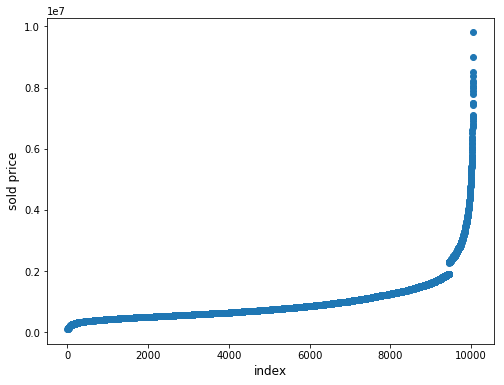

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(range(data.shape[0]), np.sort(data['Sold Price'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('sold price', fontsize=12)
plt.show()


124800 257940.0


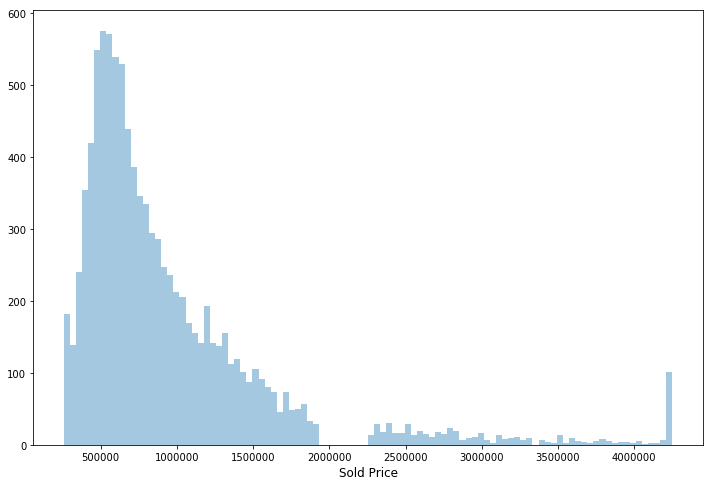

In [8]:
data['Years_old'] = 2019-data['Year Built']
data[data['Years_old']==2019] = 0  

for i in range(len(data)):
    if data['Sold Price'][i]==0:
        data['Sold Price'][i] = 0.9* data['List Price'][i]
        data['Sold Date'][i] = data['List Price'][i]
        if data['List Price'][i] == 0:
       
            data =data.drop(i)
ulimit = np.percentile(data['Sold Price'].values, 99)
llimit = np.percentile(data['Sold Price'].values, 1)

data['Sold Price'].ix[data['Sold Price']>ulimit] = ulimit
data['Sold Price'].ix[data['Sold Price']<llimit] = llimit        
        
print(data['List Price'].min(), data['Sold Price'].min())
plt.figure(figsize=(12,8))
sns.distplot(data['Sold Price'].values, bins=100, kde=False)
plt.xlabel('Sold Price', fontsize=12)
plt.show()

## Transaction Date  --number of transactions per month

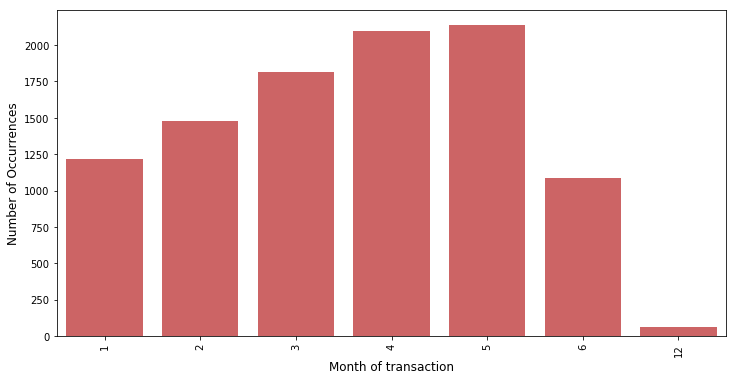

In [9]:
data['transaction_month'] = data['Sold Date'].dt.month

cnt_srs = data['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()


In [10]:
data.head()

,Address,MLS No,Penthouse,Renovation,Cats,Dogs,Ocean View,City View,Mountain View,Park View,...,Sold Price,Sold Price per SqFt,List Date,Sold Date,Days on Market,latitude,longitude,postcode,Years_old,transaction_month
2,8 11900 228 STREET,2338780,0,0,0,0,0,0,0,0,...,257940.0,278.09,2019-02-05 00:00:00,2019-02-09 00:00:00,4,49.218289,-122.589817,V2X 6L9,38,2
3,205 211 W 3RD STREET,2358205,0,0,0,0,0,0,0,0,...,420000.0,506.63,2019-04-09 00:00:00,2019-04-11 00:00:00,2,36.152670,-95.993908,74103,46,4
4,3273 MATHERS AVENUE,2324063,0,0,0,0,1,1,0,1,...,4250720.0,732.26,2018-11-19 00:00:00,2019-01-22 00:00:00,64,49.342969,-123.207228,V7V 2K6,13,1
5,642 SOUTHBOROUGH DRIVE,2360583,0,1,0,0,1,1,0,1,...,4250720.0,518.08,2019-04-18 00:00:00,2019-04-23 00:00:00,5,43.627312,-70.334353,04106,26,4
6,6610 CHURCHILL STREET,2307898,0,0,0,0,0,0,0,0,...,4250720.0,1075.00,2018-09-18 00:00:00,2019-02-11 00:00:00,146,49.225903,-123.141345,V6P 5B1,45,2


In [11]:
# checking for repeats!

(data['MLS No'].value_counts().reset_index())['MLS No'].value_counts()

# EDA

1    9889
Name: MLS No, dtype: int64

In [12]:
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']
quantitative.remove('Sold Price')
quantitative.remove('List Price')
quantitative.remove('Sold Price per SqFt')
quantitative.remove('Year Built')
quantitative.remove('MLS No')
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']
qualitative

['Address', 'List Date', 'Sold Date', 'postcode']

In [13]:
quantitative

['Penthouse',
 'Renovation',
 'Cats',
 'Dogs',
 'Ocean View',
 'City View',
 'Mountain View',
 'Park View',
 'Balcony',
 'Storage',
 'Pool',
 'Laundry',
 'Gym',
 'Finished Floor',
 'Lot Size',
 'Parking Space',
 'Fireplace',
 'Bedrooms',
 'Total Bathrooms',
 'Half Baths',
 'Full Baths',
 'Waiting Period',
 'Floor',
 'Latitude',
 'Longitude',
 'Land Only',
 'Multifamily',
 'Residential Attached',
 'Residential Detached',
 'Residential Detached.1',
 '1/2 Duplex',
 'Apartment/Condo',
 'Duplex',
 'Other',
 'Other.1',
 'Recreational',
 'Residential Detached.2',
 'Residential Detached.3',
 'Row House (Non-Strata)',
 'Townhouse',
 'Triplex',
 'First Nations Lease',
 'Freehold NonStrata',
 'Freehold Strata',
 'Leasehold not prepaid-NonStrata',
 'Leasehold not prepaid-Strata',
 'Leasehold prepaid-NonStrata',
 'Leasehold prepaid-Strata',
 'Other.2',
 'Other.3',
 'Shares in Co-operative',
 'Undivided Interest',
 'Days on Market',
 'latitude',
 'longitude',
 'Years_old',
 'transaction_month']

# Outliers

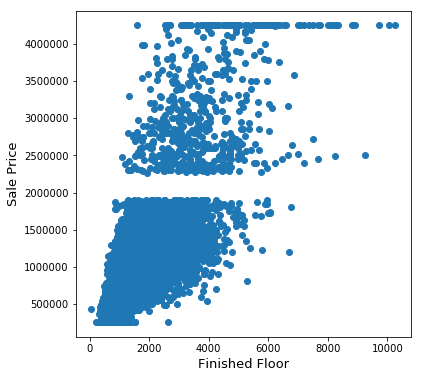

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x = data['Finished Floor'], y = data['Sold Price'])
plt.ylabel('Sale Price', fontsize=13)
plt.xlabel('Finished Floor', fontsize=13)
plt.show()

## removing outliers

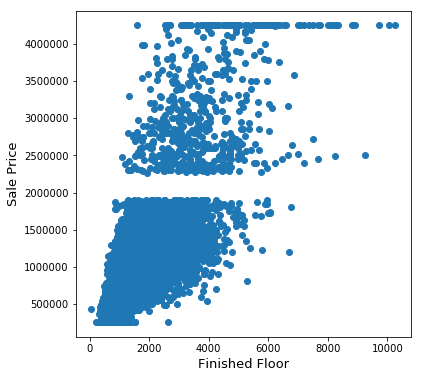

In [15]:
data = data.drop(data[(data['Finished Floor']>6000) & (data['Sold Price']<300000)].index)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x = data['Finished Floor'], y = data['Sold Price'])
plt.ylabel('Sale Price', fontsize=13)
plt.xlabel('Finished Floor', fontsize=13)
plt.show()


 mu = 954236.23 and sigma = 683180.43



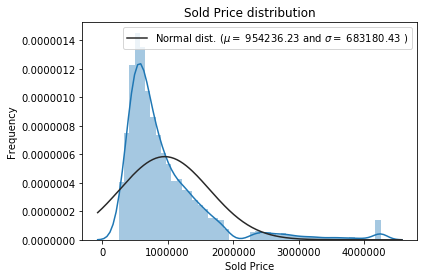

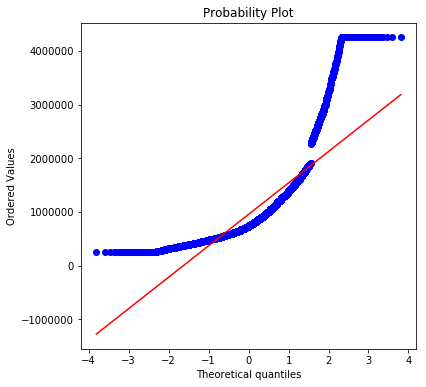

In [16]:
sns.distplot(data['Sold Price'] , fit=norm);
(mu, sigma) = norm.fit(data['Sold Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sold Price distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(6,6))
res = stats.probplot(data['Sold Price'], plot=plt)
plt.show()


 mu = 13.59 and sigma = 0.56



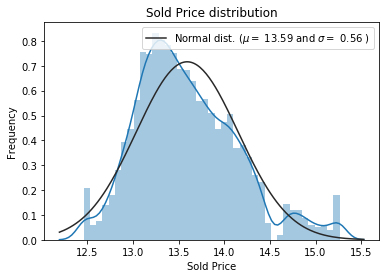

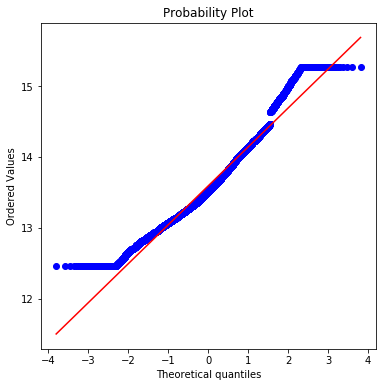

In [17]:
data["Sold Price"] = np.log1p(data["Sold Price"])

#Check the new distribution 
sns.distplot(data['Sold Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['Sold Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sold Price distribution')

#Get also the QQ-plot
fig = plt.figure(figsize = (6,6))
res = stats.probplot(data['Sold Price'], plot=plt)
plt.show()

In [18]:
from scipy import stats
z = np.abs(stats.zscore(data['Sold Price']))
threshold = 3
print(np.where(z > 3))

Q1 = data['Sold Price'].quantile(0.25)
Q3 = data['Sold Price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print(Q1)
print(Q3)

(array([], dtype=int64),)
0.7476821929097817
13.197101579492868
13.94478377240265


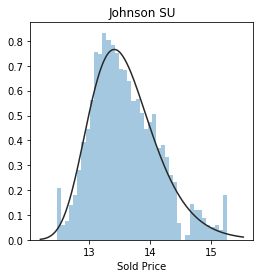

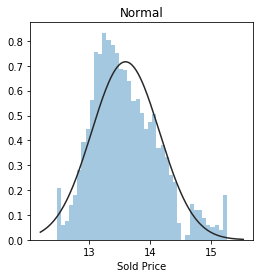

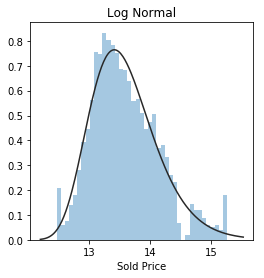

In [19]:
y = data['Sold Price']
plt.figure(1, figsize=(4,4)); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2,figsize=(4,4)); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3, figsize=(4,4)); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

It is apparent that Sale Price doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

In [20]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(data[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())


False


## Feature Engineering


In [21]:

X = data[quantitative].fillna(0.).values
y = data['Sold Price'].reset_index(drop=True)


x_train, x_valid_test, y_train, y_valid_test = train_test_split(X , y, test_size=0.2, random_state=42)
print('x_train shape={}'.format(x_train.shape))
x_test, x_valid, y_test, y_valid = train_test_split(x_valid_test ,y_valid_test , test_size=0.5, random_state=42)
print('x_valid shape={}'.format(x_valid.shape))
y_test


ntrain = x_train.shape[0]
ntest = x_test.shape[0]
print(ntrain)

x_train shape=(7911, 57)
x_valid shape=(989, 57)
7911


Text(0.5, 1.0, 'Percent missing data by feature')

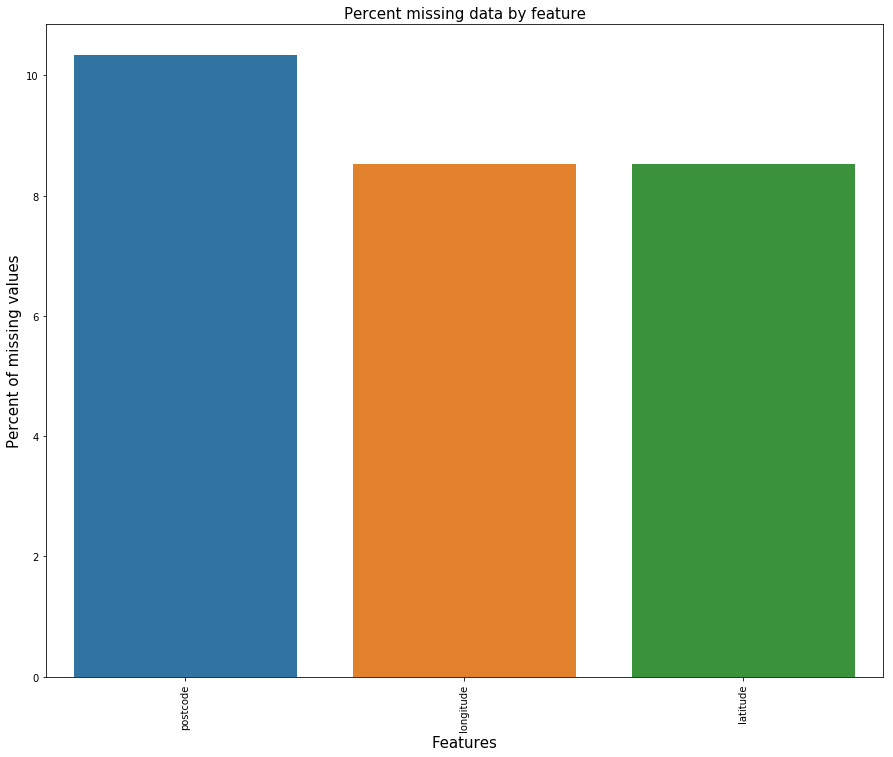

In [22]:
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [23]:
missing_data.head(20)

,Missing Ratio
postcode,10.334715
longitude,8.524623
latitude,8.524623


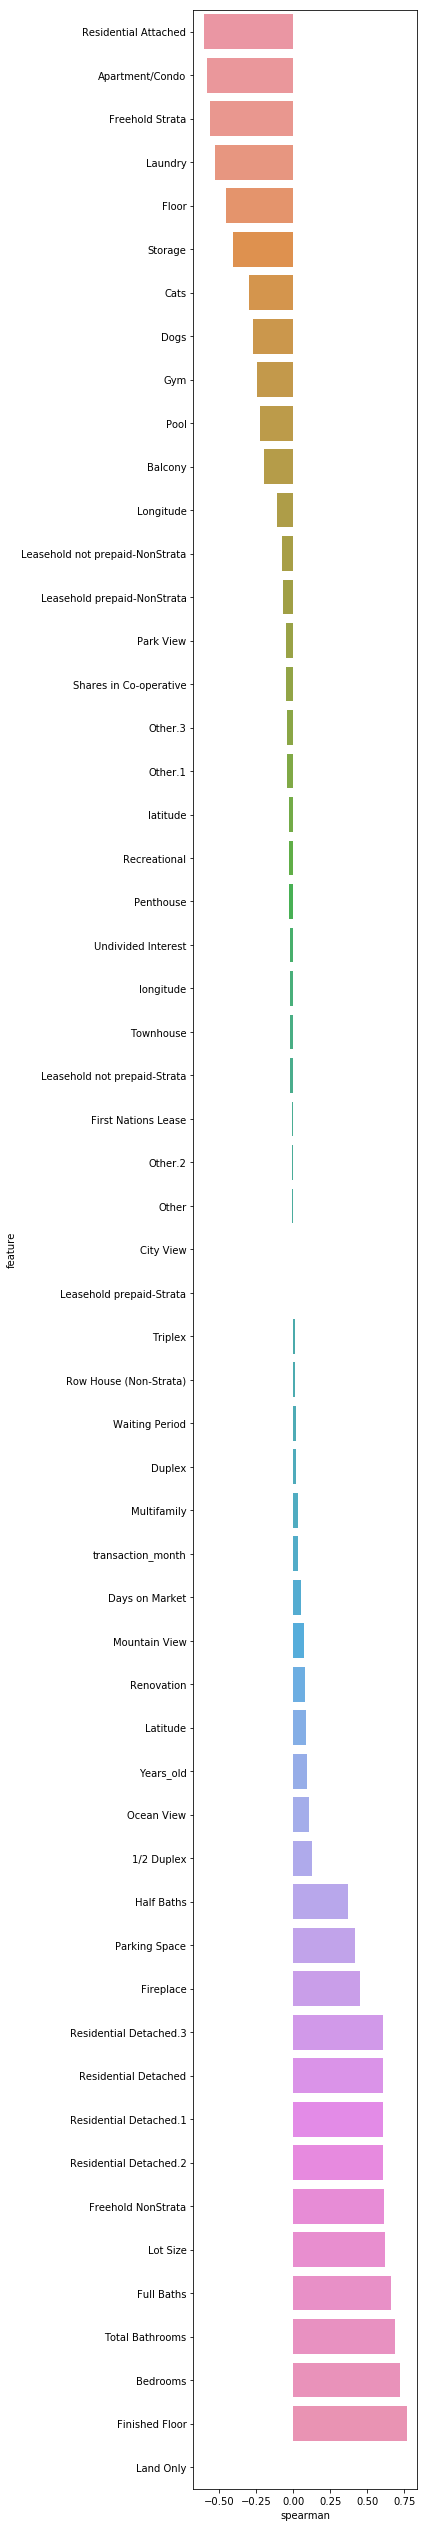

In [24]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Sold Price'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(4, 0.8*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
spearman(data, quantitative)
features = quantitative

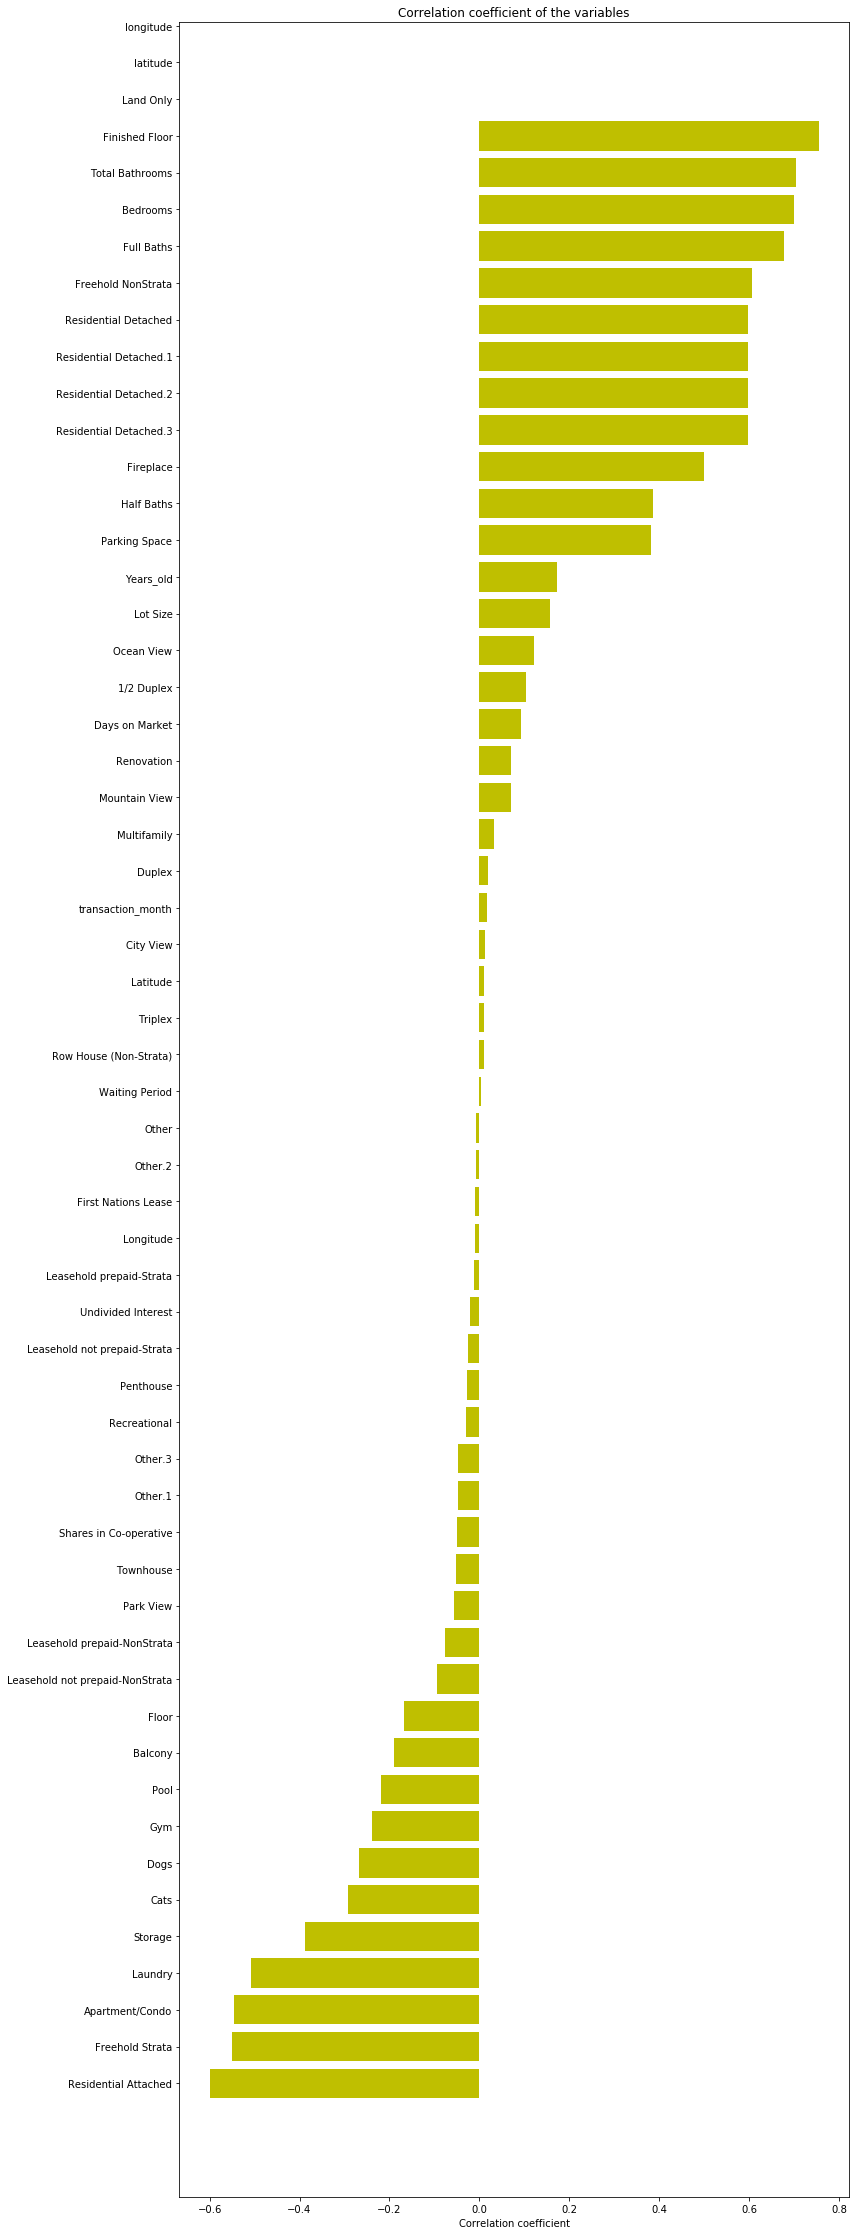

In [25]:

labels = []
values = []
for col in features:
    labels.append(col)
    values.append(np.corrcoef(data[col].values, data['Sold Price'].values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [26]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel


# very wiered correlation matrix! ocien view, gym, pool, floor, years old, 

,col_labels,corr_values
27,Residential Attached,-0.599339
43,Freehold Strata,-0.549334
31,Apartment/Condo,-0.545900
11,Laundry,-0.508967
9,Storage,-0.387084
2,Cats,-0.292256
3,Dogs,-0.266968
12,Gym,-0.239821
10,Pool,-0.217772
8,Balcony,-0.189483


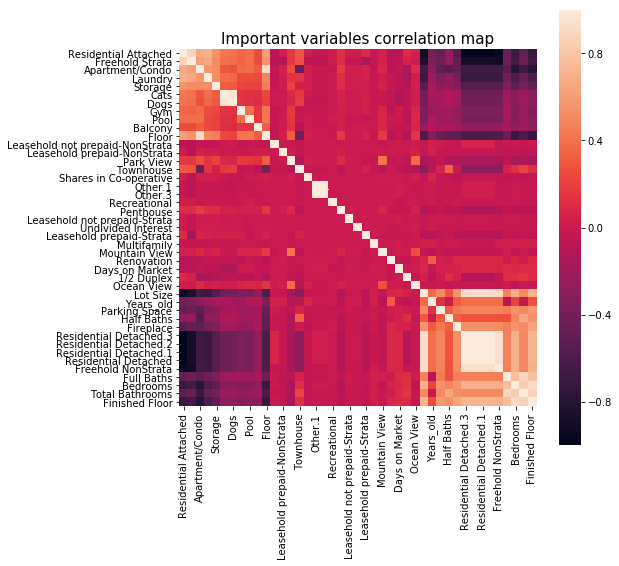

In [27]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = data[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

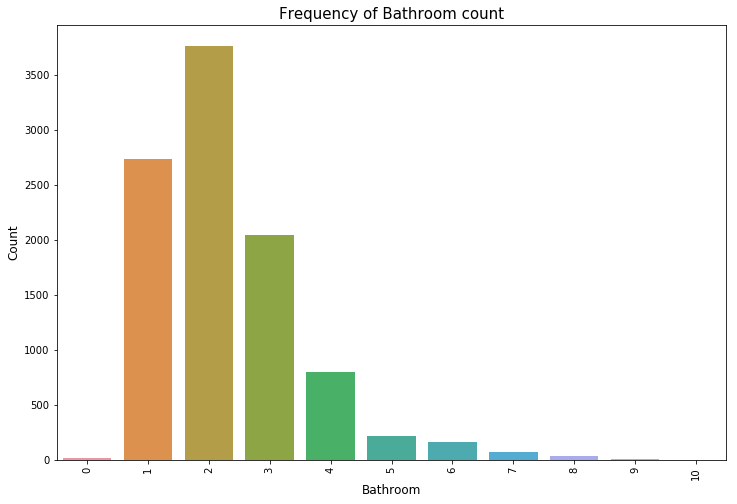

In [28]:
plt.figure(figsize=(12,8))
sns.countplot(x="Total Bathrooms", data=data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

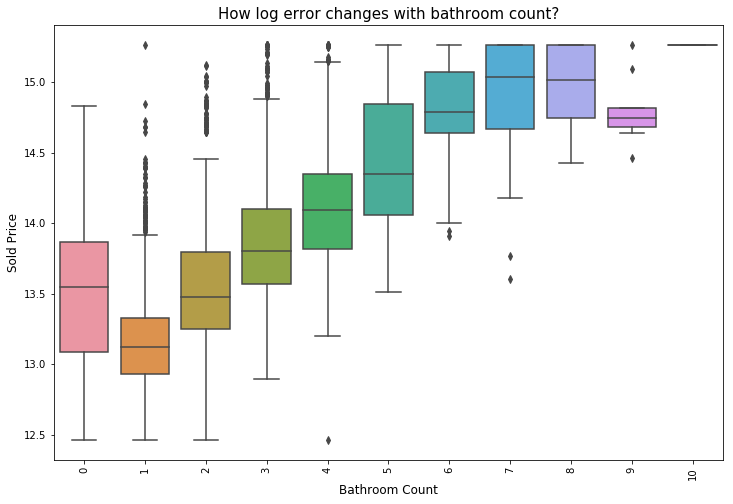

In [29]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Total Bathrooms", y="Sold Price", data=data)
plt.ylabel('Sold Price', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

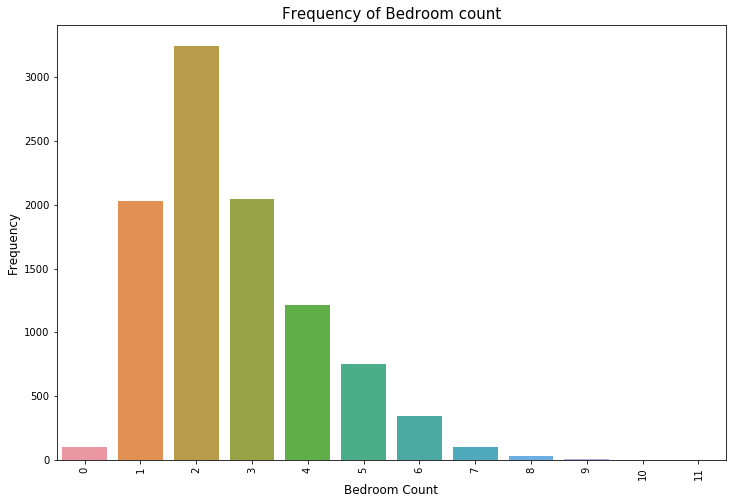

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x="Bedrooms", data=data)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

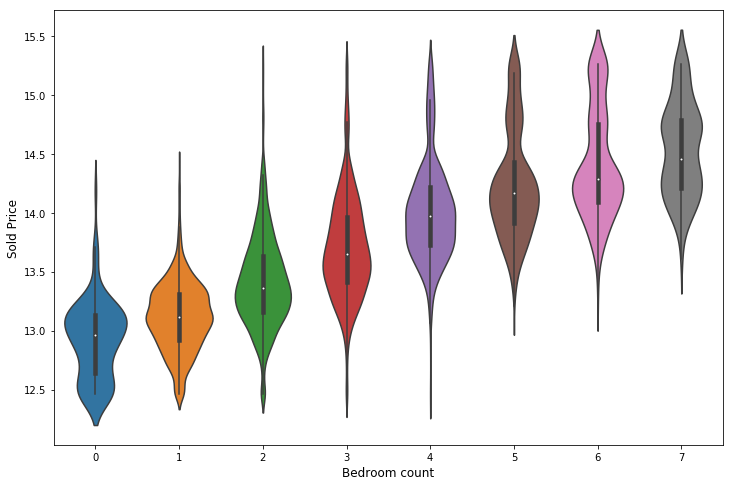

In [31]:
data['Bedrooms'].ix[data['Bedrooms']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='Bedrooms', y='Sold Price', data=data)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Sold Price', fontsize=12)
plt.show()

### Simple clustering using geo location


In [32]:

from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

data.dropna(axis=0,subset=['longitude'],inplace=True)
data.dropna(axis=0,subset=['latitude'],inplace=True)
data.dropna(axis=0,subset=['postcode'],inplace=True)
print(len(data))
x_geo=data.loc[:,['latitude','longitude']]
id_n=10
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(x_geo)
id_label=kmeans.labels_
print(len(x_geo))



8867
8867


<Figure size 864x864 with 0 Axes>

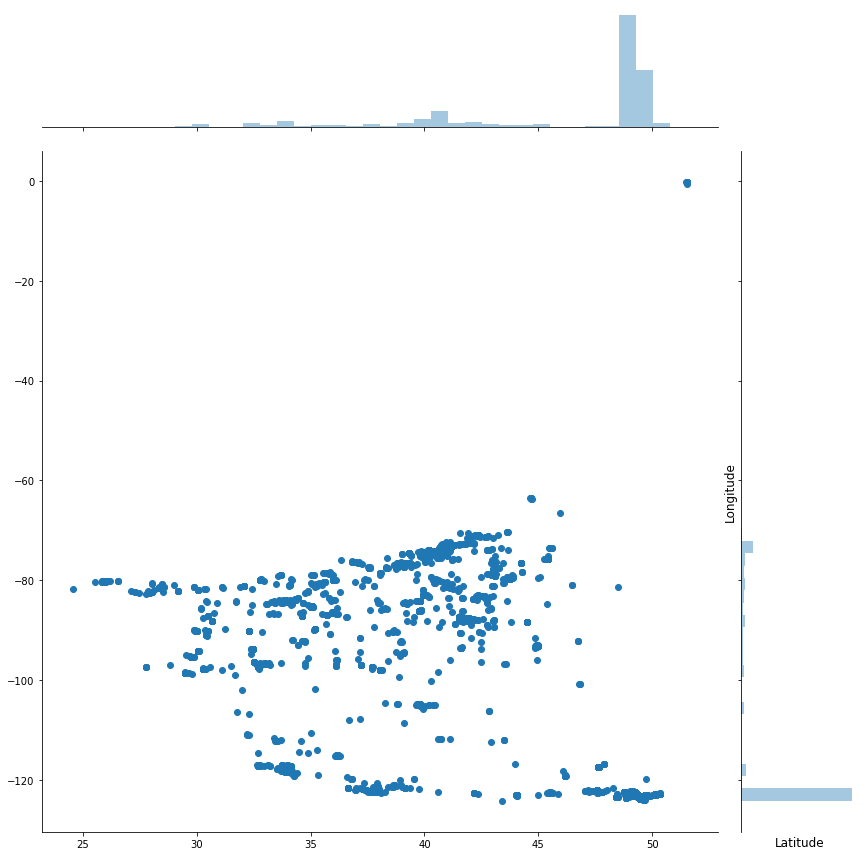

In [33]:
plt.figure(figsize=(12,12))
sns.jointplot(x=data.latitude.values, y=data.longitude.values, size=12)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()



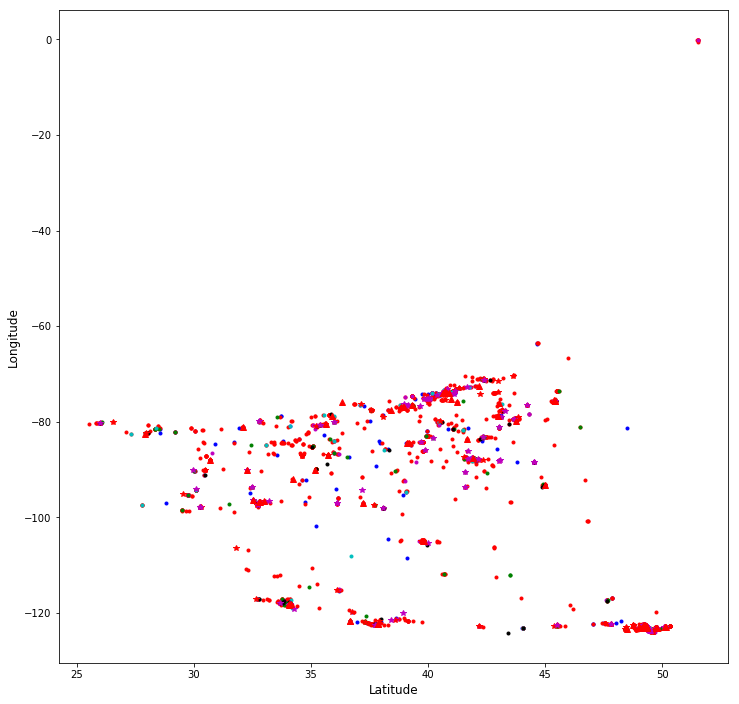

In [34]:
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(x_geo.latitude[cluster].values,x_geo.longitude[cluster].values,ptsymb[i])
plt.show()

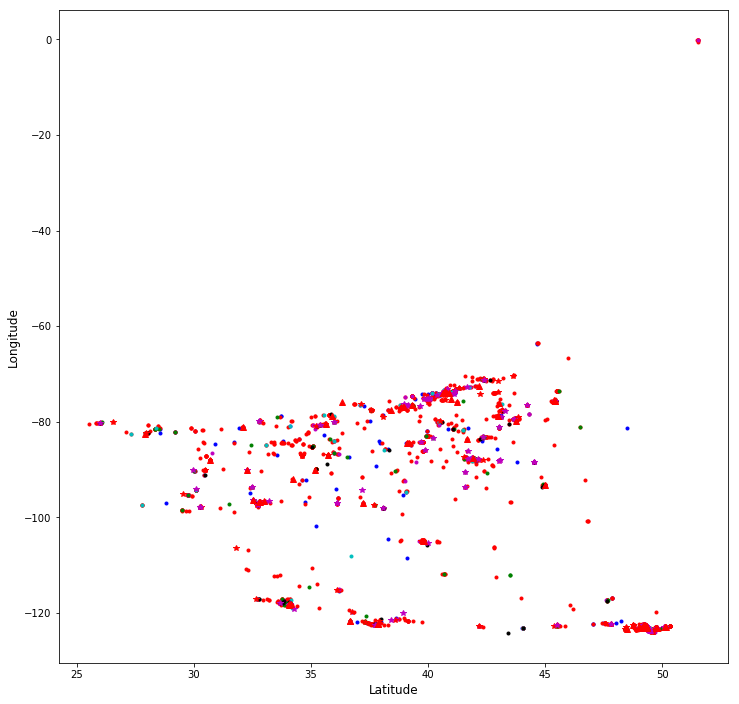

In [35]:
#revise the clustering based on postcode
from collections import Counter

zp=data.postcode
uniq_zp=np.unique(zp)
for i in uniq_zp:
    a=np.where(zp==i)[0]
    c = Counter(id_label[a])
    c.most_common(1)[0][0]
    id_label[a]=c.most_common(1)[0][0]
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(x_geo.latitude[cluster].values,x_geo.longitude[cluster].values,ptsymb[i])
plt.show()

# Geographic Location by Folium and Cluster by KMeans¶


In [36]:
import folium
geo_df = data[['latitude', 'longitude', 'Sold Price']]



In [37]:

geo_df.head()

,latitude,longitude,Sold Price
2,49.218289,-122.589817,12.460486
3,36.152670,-95.993908,12.948012
4,49.342969,-123.207228,15.262599
5,43.627312,-70.334353,15.262599
6,49.225903,-123.141345,15.262599


In [38]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=120, batch_size=1000).fit(geo_df[['latitude','longitude']])
geo_df.loc[:, 'label'] = kmeans.labels_
map_2 = folium.Map(location=[49.28, -123.12],
                   zoom_start=9)
for label in kmeans.cluster_centers_:
    folium.Marker(location=[label][0]).add_to(map_2)

In [39]:
map_2

In [40]:
map_1 = folium.Map(location=[49.28, -123.12], zoom_start=9,
                   tiles='Stamen Terrain')
for label in kmeans.cluster_centers_:
    folium.Marker(location=[label][0]).add_to(map_1)
map_1

#### it would be beneficial to cluster properties data according to this map


# PCA

Text(0, 0.5, 'cumulative explained variance')

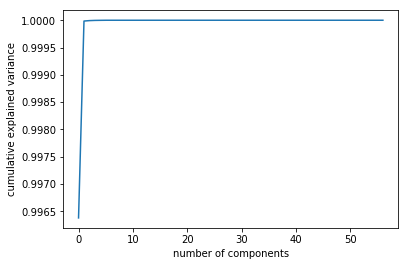

In [41]:
X = data[features].fillna(0.).values
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

0.9905119779112528


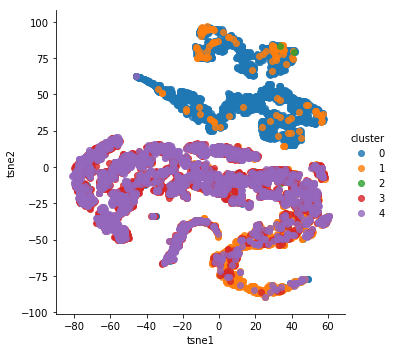

In [42]:
features = quantitative
model = TSNE(n_components=2, random_state=0, perplexity=40)
X = data[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=40)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

# Models

### Data processing

In [43]:
#data.columns

In [44]:

data.reset_index(drop=True, inplace=True)

y = data['Sold Price'].reset_index(drop=True)
#y.head()
#z = np.expm1(y)


### Features

In [45]:

X = data[features]



In [46]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [47]:
y.shape  

(8867,)

In [48]:

prepro_y = MinMaxScaler()
Y_neural = np.array(y).reshape(8867,1)
prepro_y.fit(Y_neural)
prepro_x = MinMaxScaler()
prepro_x.fit(X)
X_neural = prepro_x.transform(X)
x_train, x_valid_test, y_train, y_valid_test = train_test_split(X_neural , Y_neural, test_size=0.2, random_state=42)
print('x_train shape={}'.format(x_train.shape))
x_test, x_valid, y_test, y_valid = train_test_split(x_valid_test ,y_valid_test , test_size=0.5, random_state=42)
print('x_valid shape={}'.format(x_valid.shape))


x_train shape=(7093, 57)
x_valid shape=(887, 57)


In [49]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model  
seed = 7
np.random.seed(seed)


def basic_model(x_size, y_size):
    
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model) 


def basic_model2(x_size, y_size):
    
    t_model = Sequential()
    t_model.add(Dense(1024, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(1024, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(512, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(512, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model) 
model = basic_model(x_train.shape[1],y_train.shape[1])
                    
epochs = 500
batch_size = 128                   
                    
keras_callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=30, verbose=0)
]  

history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(x_valid, y_valid),
    callbacks=keras_callbacks)
                    
train_score = model.evaluate(x_train, y_train, verbose=0)
valid_score = model.evaluate(x_valid, y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train MAE:  0.2812 , Train Loss:  0.4614
Val MAE:  0.279 , Val Loss:  0.4606


In [50]:
model2 = basic_model2(x_train.shape[1],y_train.shape[1])
                    
epochs = 500
batch_size = 128                   
                    
keras_callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=30, verbose=0)
]  

history = model2.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(x_valid, y_valid),
    callbacks=keras_callbacks)
                    
train_score = model2.evaluate(x_train, y_train, verbose=0)
valid_score = model2.evaluate(x_valid, y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  0.2412 , Train Loss:  4.0588
Val MAE:  0.2476 , Val Loss:  4.0668


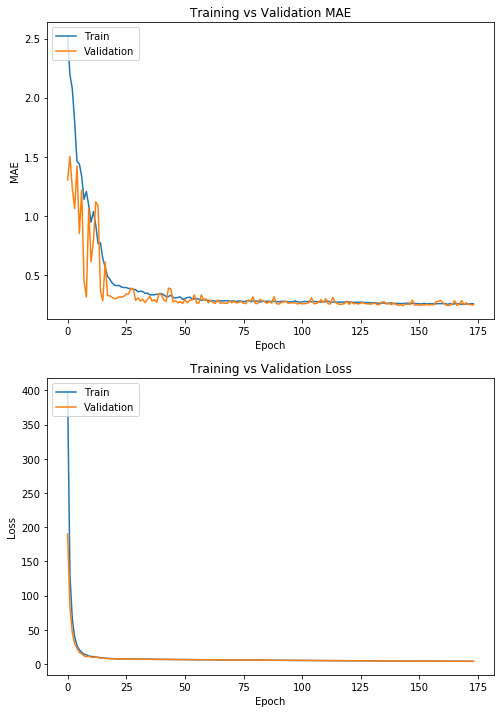

In [51]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return
plot_hist(history.history, xsize=8, ysize=12)


In [52]:


y_predict = model.predict(x_test)
predictions = prepro_y.inverse_transform((y_predict.reshape(-1,1)))
model.predict(prepro_x.transform(X))
print(y_predict.shape)
reality = prepro_y.inverse_transform(y_test)

#reality
print(reality[0])
print(predictions[0])


(887, 1)
[49.96601003]
[49.751278]


In [53]:

y_predict = model.predict(x_test)
#y_predict.reshape(-1,1)

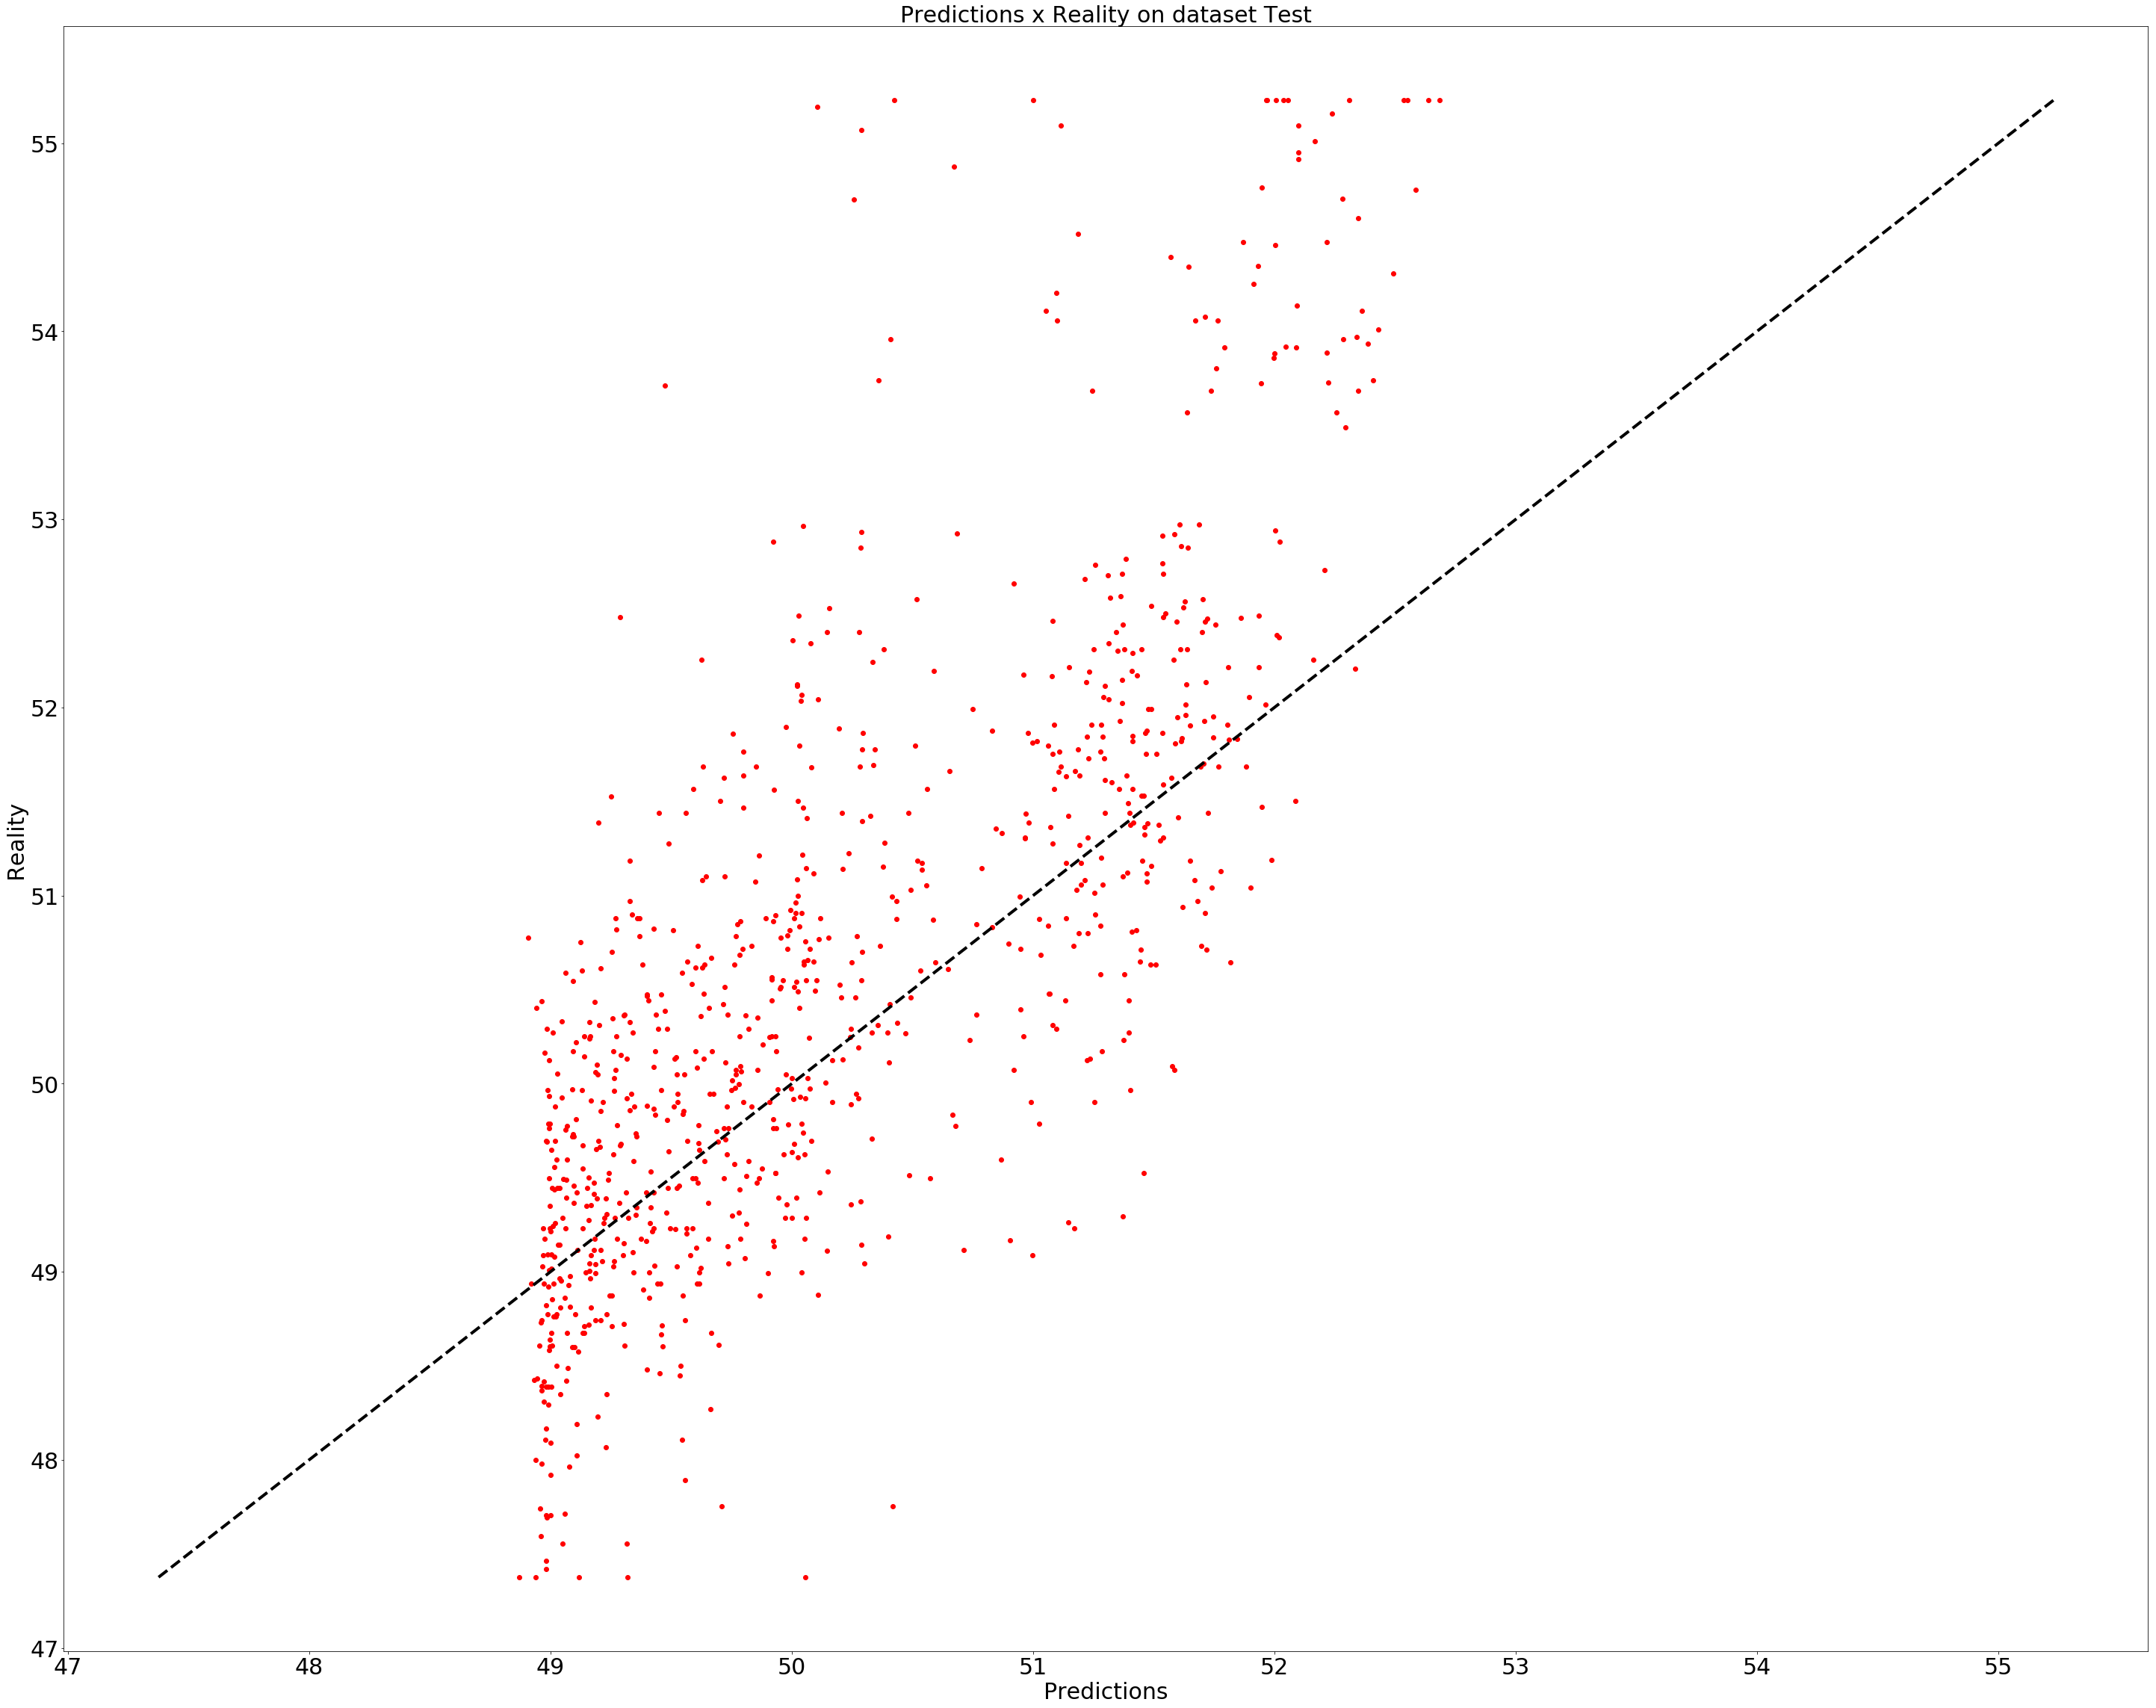

In [54]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()


In [55]:
y_test.shape



(887, 1)

In [56]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

In [57]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [58]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [59]:
gbr = GradientBoostingRegressor(n_estimators=4000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

In [60]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=3,
                                       learning_rate=0.01, 
                                       n_estimators=4000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [61]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [62]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [63]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.3203 (0.0087)
 2019-07-15 15:35:07.843154
elastic net: 0.3203 (0.0088)
 2019-07-15 15:35:21.082595
SVR: 0.3125 (0.0099)
 2019-07-15 15:36:13.408358
lightgbm: 0.2116 (0.0076)
 2019-07-15 15:36:24.846855
gbr: 0.1603 (0.0058)
 2019-07-15 15:39:14.796850
xgboost: 0.1797 (0.0082)
 2019-07-15 15:40:11.492513


In [64]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(x_train), np.array(y_train))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(x_train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(x_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(x_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(x_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(x_train, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(x_train, y_train)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(x_train, y_train)

START Fit
stack_gen
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
lightgbm


# Blending Models

In [65]:
print(x_test.shape)
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X).reshape(887,)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.2 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.1*model2.predict(X)).reshape(887,))+\
            (0.15 * stack_gen_model.predict(np.array(X)))



blend_models_predict(x_test).shape
#ridge_model_full_data.predict(x_test).reshape(1508,).shape
#model.predict(prepro_x.transform(X)).reshape(1453,).shape

(887, 57)


(887,)

In [66]:
print(blend_models_predict(x_test).shape)
print(y_test.shape)
print('RMSLE score on train data:')
print('blend' ,rmsle(y_test, blend_models_predict(x_test)))
print('xgb' ,rmsle(y_test, xgb_model_full_data.predict(x_test)))
print('model2' ,rmsle(y_test, model2.predict(x_test)))
print('lgb' ,rmsle(y_test, lgb_model_full_data.predict(x_test)))
print('gbr' ,rmsle(y_test, gbr_model_full_data.predict(x_test)))
print('svr' ,rmsle(y_test, svr_model_full_data.predict(x_test)))
print('rdige' ,rmsle(y_test, ridge_model_full_data.predict(x_test)))
print('lasso' ,rmsle(y_test, lasso_model_full_data.predict(x_test)))
print('elastic' ,rmsle(y_test, elastic_model_full_data.predict(x_test)))
print('stack' ,rmsle(y_test, stack_gen_model.predict(x_test)))

(887,)
(887, 1)
RMSLE score on train data:
blend 0.21819119846010063
xgb 0.18091035995120877
model2 0.31813890991366484
lgb 0.22012516413784952
gbr 0.15884528007480353
svr 0.31544402192445287
rdige 0.3309843611922002
lasso 0.33009845991270215
elastic 0.3300166589757886
stack 0.15819897952952494


In [67]:
def blend_models_optimized(X):
    return ((0.3 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.5 * stack_gen_model.predict(np.array(X))))
print('optimized' ,rmsle(y_test, blend_models_optimized(x_test)))


optimized 0.16068311486903256


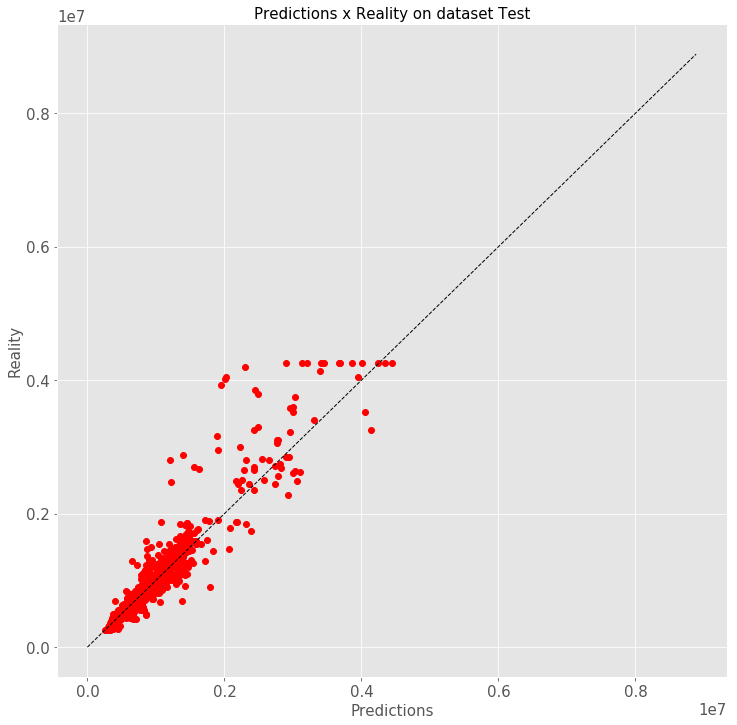

In [68]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

preds = np.expm1(blend_models_optimized(x_test))
reality = np.expm1(y_test)
fig, ax = plt.subplots(figsize=(12, 12))

plt.style.use('ggplot')
plt.plot(preds, reality, 'ro')
plt.xlabel('Predictions', fontsize =15)
plt.ylabel('Reality', fontsize = 15)
plt.title('Predictions x Reality on dataset Test', fontsize = 15)
ax.plot([np.expm1(0),np.expm1(16)], [np.expm1(0),np.expm1(16)], 'k--', lw=1)
plt.show()


# pure model xgb try!

In [69]:
import xgboost as xgb
import lightgbm as lgb
import gc
y_mean = np.mean(y_train)

xgb_params = {
    'eta': 0.037,
    'max_depth': 6,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}
dtrain = xgb.DMatrix(x_train, y_train)

In [70]:
# cross-validation
print( "Running XGBoost CV ..." )
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   nfold=5,
                   num_boost_round=350,
                   early_stopping_rounds=50,
                   verbose_eval=10, 
                   show_stdv=False
                  )
num_boost_rounds = len(cv_result)



Running XGBoost CV ...
[0]	train-mae:0.432012	test-mae:0.432279
[10]	train-mae:0.326447	test-mae:0.330071
[20]	train-mae:0.258372	test-mae:0.265909
[30]	train-mae:0.213778	test-mae:0.225307
[40]	train-mae:0.183937	test-mae:0.199098
[50]	train-mae:0.163542	test-mae:0.181634
[60]	train-mae:0.148775	test-mae:0.169441
[70]	train-mae:0.137695	test-mae:0.160603
[80]	train-mae:0.129221	test-mae:0.154102
[90]	train-mae:0.122548	test-mae:0.148982
[100]	train-mae:0.116975	test-mae:0.144737
[110]	train-mae:0.112217	test-mae:0.141201
[120]	train-mae:0.108732	test-mae:0.138653
[130]	train-mae:0.105463	test-mae:0.136392
[140]	train-mae:0.102524	test-mae:0.134493
[150]	train-mae:0.0997826	test-mae:0.132818
[160]	train-mae:0.0975068	test-mae:0.131442
[170]	train-mae:0.0955974	test-mae:0.130364
[180]	train-mae:0.093856	test-mae:0.129341
[190]	train-mae:0.092039	test-mae:0.128305
[200]	train-mae:0.0903994	test-mae:0.127481
[210]	train-mae:0.0887192	test-mae:0.126501
[220]	train-mae:0.087311	test-mae:0.1

In [71]:

d_train = lgb.Dataset(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

xgbmodel = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
xgb_pred = xgbmodel.predict(dtest)
print( pd.DataFrame(xgb_pred).head() )
print('XGB' ,rmsle(y_test, xgbmodel.predict(dtest)))

           0
0  13.447088
1  13.275329
2  13.767457
3  13.805325
4  13.100382
XGB 0.16784208203430798


In [72]:
XGB_WEIGHT = 0.4
x_test = x_test.astype(np.float32, copy=False)

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=50,
                                       learning_rate=0.01, 
                                       n_estimators=20000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

clf = lightgbm.fit(x_train, y_train)



print('lgb' ,rmsle(y_test, clf.predict(x_test)))

print( "\nCombining XGBoost, LightGBM, and baseline predicitons ..." )


lgb 0.1665089852386154

Combining XGBoost, LightGBM, and baseline predicitons ...


In [73]:
def XGB_LGB_model(X):
    return (0.50*xgbmodel.predict(xgb.DMatrix(X))+0.5*clf.predict(X))
print('XGB_LGB' ,rmsle(y_test, XGB_LGB_model(x_test)))

XGB_LGB 0.16138793833756715


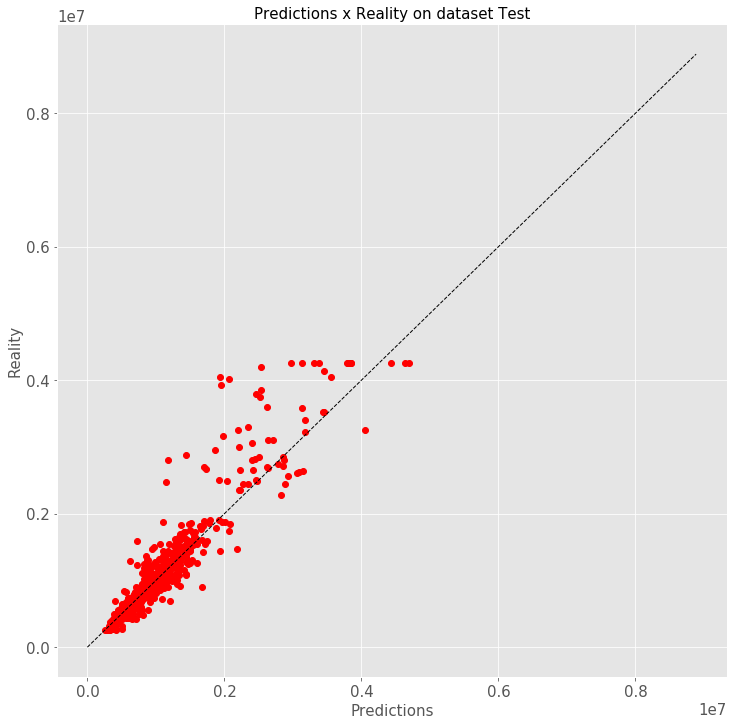

In [74]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

preds = np.expm1(XGB_LGB_model(x_test))
reality = np.expm1(y_test)
fig, ax = plt.subplots(figsize=(12, 12))

plt.style.use('ggplot')
plt.plot(preds, reality, 'ro')
plt.xlabel('Predictions', fontsize =15)
plt.ylabel('Reality', fontsize = 15)
plt.title('Predictions x Reality on dataset Test', fontsize = 15)
ax.plot([np.expm1(0),np.expm1(16)], [np.expm1(0),np.expm1(16)], 'k--', lw=1)
plt.show()

# Time series analysis


# New Section

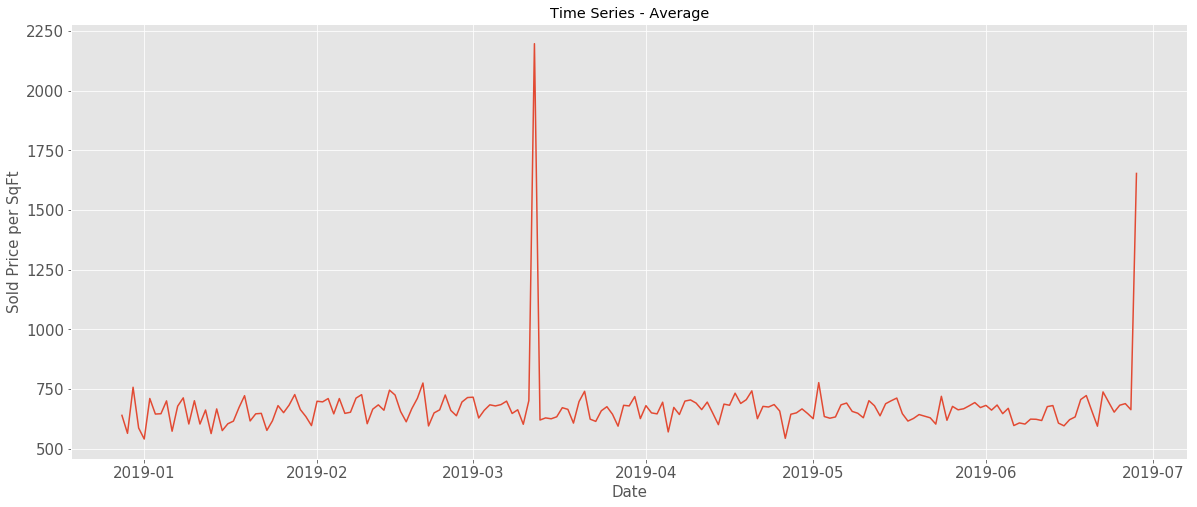

In [88]:
df_train = data
data = pd.read_csv('data.csv')
data= data[data['Sold Date']!=0]
data['Sold Date'] = pd.to_datetime(data['Sold Date'])
plt.figure(figsize=(20, 8))
mean_group = df_train[['Sold Date','Sold Price per SqFt']].groupby(['Sold Date'])['Sold Price per SqFt'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sold Price per SqFt', fontsize=15)
plt.title('Time Series - Average')
plt.show()
# this shows the importance of grouping by average price per square fit


In [89]:
data = pd.read_csv('data.csv')

In [115]:

data= data[data['Sold Date']!=0]
data['Sold Date'] = pd.to_datetime(data['Sold Date'])
Price = data [[ 'Sold Price per SqFt', 'Sold Date']]
price_groups = pd.DataFrame()

price_groups['500'] = Price[Price['Sold Price per SqFt'] <= 500 ].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()
price_groups['500-750'] = Price[Price['Sold Price per SqFt'].between(500, 750, inclusive = True)].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()
price_groups['750-1000'] = Price[Price['Sold Price per SqFt'].between(750, 1000, inclusive = True)].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()
price_groups['1000-1250'] = Price[Price['Sold Price per SqFt'].between(1000, 1250, inclusive = True)].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()

price_groups['1250-1500'] = Price[Price['Sold Price per SqFt'].between(1250, 1500, inclusive = True)].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()
price_groups['1500-1750'] = Price[Price['Sold Price per SqFt'].between(1500, 1750, inclusive = True)].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()
price_groups['1750-2000'] = Price[Price['Sold Price per SqFt'].between(1750,2000, inclusive = True)].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()
price_groups['2000+'] = Price[Price['Sold Price per SqFt'].between(2000,4000, inclusive = True)].groupby('Sold Date').mean().resample('W')['Sold Price per SqFt'].mean()


In [116]:

from keras.preprocessing import sequence


In [117]:
price_groups= price_groups.interpolate(axis = 1, limit_direction ='both')
price_groups_500_1250 = price_groups[['500', '500-750', '750-1000','1000-1250']]
PCG= price_groups_500_1250.interpolate(axis = 1, limit_direction ='both')
PCG.head()

,500,500-750,750-1000,1000-1250
Sold Date,,,,
2018-12-30,320.071500,618.700245,849.602500,1097.000000
2019-01-06,393.127884,594.846646,850.031762,1137.941667
2019-01-13,369.908464,622.211258,854.153372,1104.666667
2019-01-20,370.464520,602.305487,856.748653,1125.021769
2019-01-27,373.861039,618.548622,843.288066,1094.680272


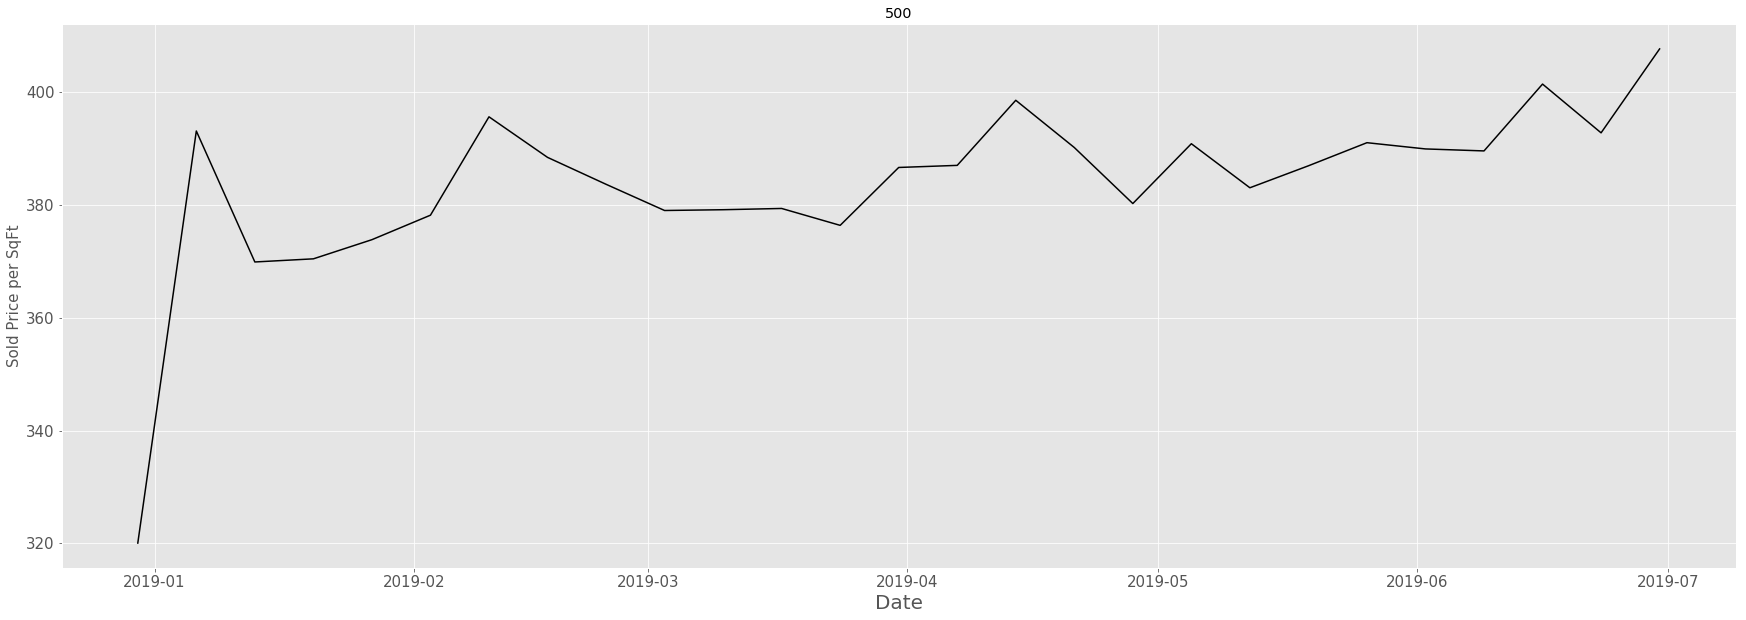

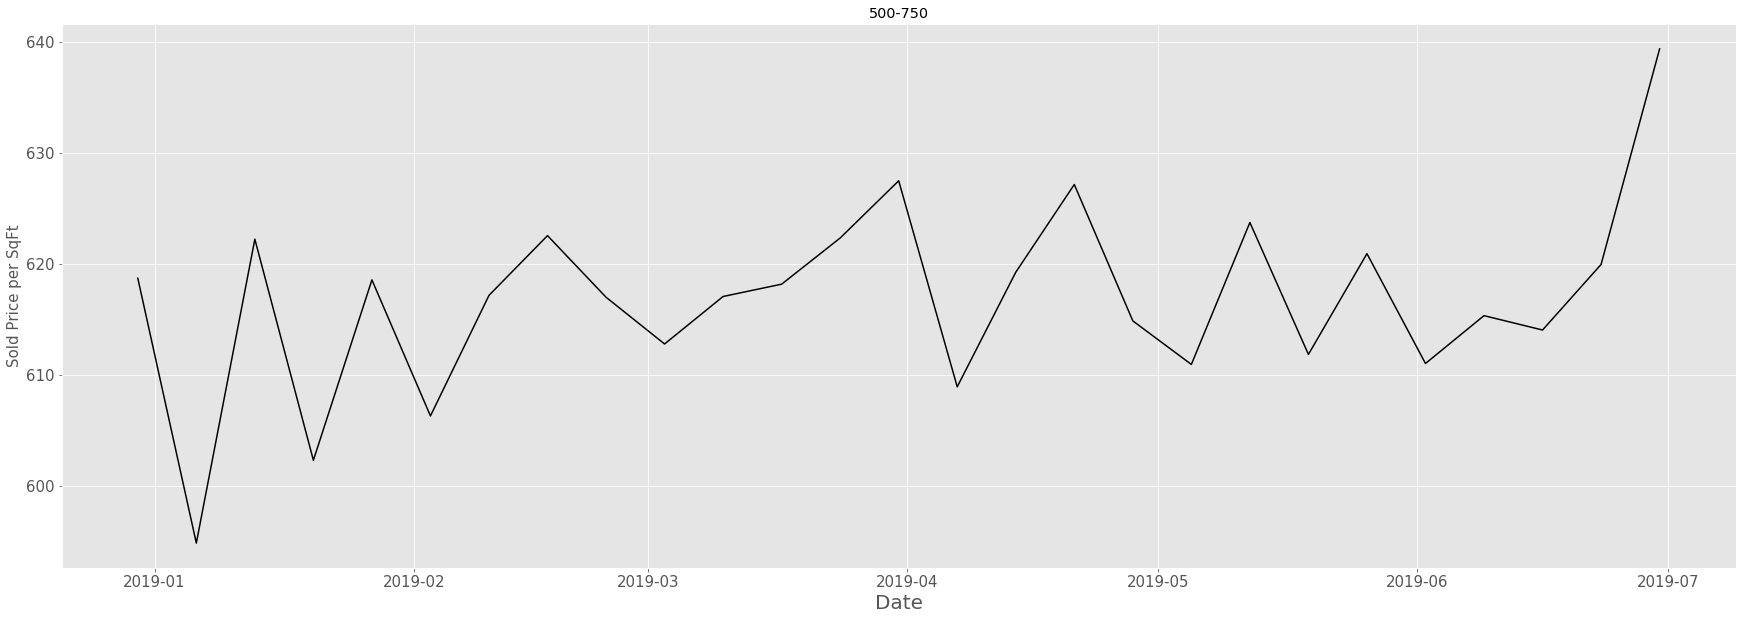

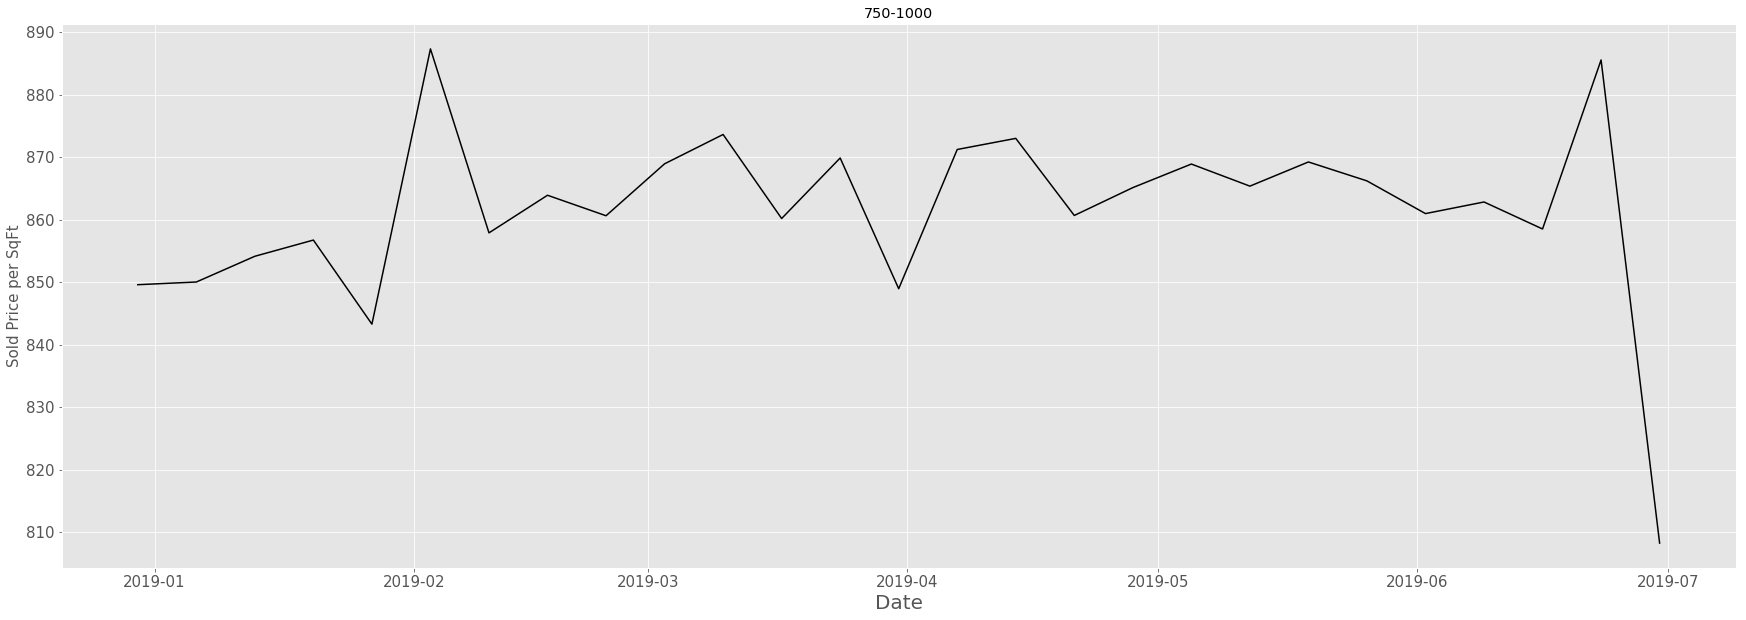

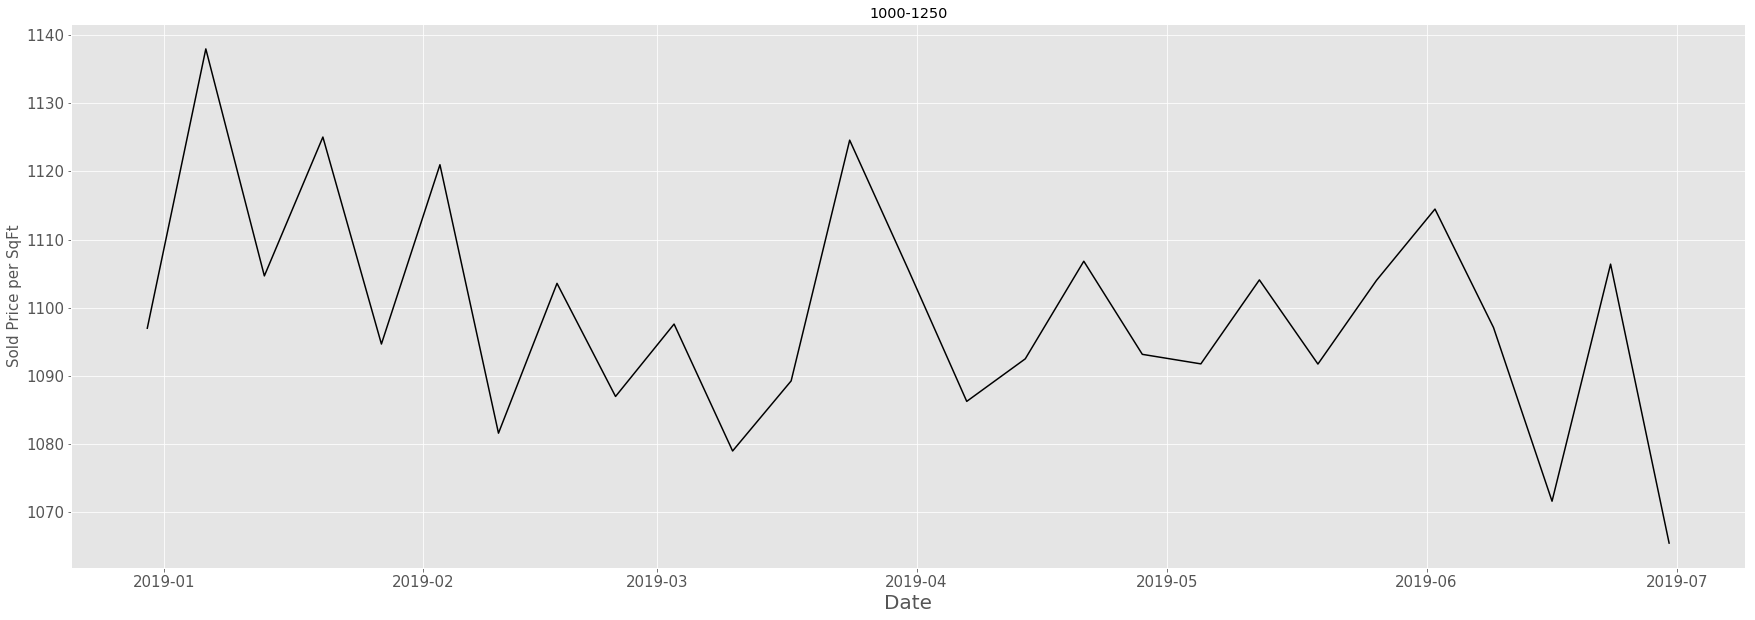

In [118]:


# specify columns to plot
columns = ['500', '500-750', '750-1000','1000-1250' ]

# plot each column
for c in columns:
    plt.figure(figsize=(30, 10))
    fips1 = pd.DataFrame(PCG[c].groupby('Sold Date').mean())
    plt.plot(fips1,c='k')
    plt.xlabel('Date', fontsize=20)
    plt.ylabel('Sold Price per SqFt', fontsize=15)
    plt.title(c)
    plt.show()



In [94]:
##### Moving Average Smoothing / Random Walk and Stationarity
#### Prophet Forecasting
 #### https://research.fb.com/prophet-forecasting-at-scale/

#### Level: The average value in the series.
#### Trend: The increasing or decreasing value in the series.
#### Seasonality: The repeating short-term cycle in the series.
#### Noise: The random variation in the series.

In [107]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

print(price_groups_500_1250.shape)
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
scaler= MinMaxScaler()
scaler.fit(price_groups_500_1250)
scaled= scaler.transform(price_groups_500_1250)
print(scaled.shape)

(181, 4)
(181, 4)


In [108]:
reframed = series_to_supervised(scaled, 1, 1)


In [109]:
reframed.head(5)
reframed.shape

(180, 8)

In [110]:
reframed.shape

(180, 8)

In [181]:
values = reframed.values
train = values[:160, :]
test = values[160:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(160, 1, 7) (160,) (20, 1, 7) (20,)


Train on 160 samples, validate on 20 samples
Epoch 1/100
 - 4s - loss: 0.5659 - val_loss: 0.4067
Epoch 2/100
 - 0s - loss: 0.4146 - val_loss: 0.2234
Epoch 3/100
 - 0s - loss: 0.1883 - val_loss: 0.1772
Epoch 4/100
 - 0s - loss: 0.1567 - val_loss: 0.2895
Epoch 5/100
 - 0s - loss: 0.1860 - val_loss: 0.1829
Epoch 6/100
 - 0s - loss: 0.0873 - val_loss: 0.1394
Epoch 7/100
 - 0s - loss: 0.1115 - val_loss: 0.1435
Epoch 8/100
 - 0s - loss: 0.1139 - val_loss: 0.1375
Epoch 9/100
 - 0s - loss: 0.0807 - val_loss: 0.1665
Epoch 10/100
 - 0s - loss: 0.0945 - val_loss: 0.1683
Epoch 11/100
 - 0s - loss: 0.0847 - val_loss: 0.1419
Epoch 12/100
 - 0s - loss: 0.0789 - val_loss: 0.1356
Epoch 13/100
 - 0s - loss: 0.0857 - val_loss: 0.1370
Epoch 14/100
 - 0s - loss: 0.0769 - val_loss: 0.1545
Epoch 15/100
 - 0s - loss: 0.0812 - val_loss: 0.1524
Epoch 16/100
 - 0s - loss: 0.0757 - val_loss: 0.1372
Epoch 17/100
 - 0s - loss: 0.0773 - val_loss: 0.1350
Epoch 18/100
 - 0s - loss: 0.0767 - val_loss: 0.1436
Epoch 19/1

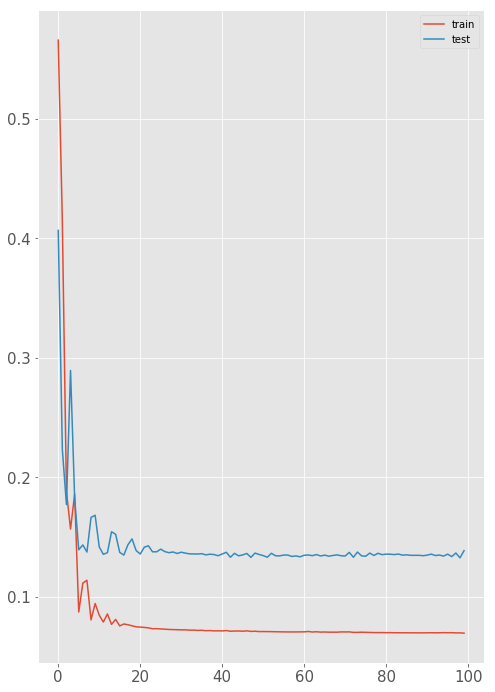

In [182]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, LSTM, Bidirectional
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model  
# design network
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(512))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
train_score = model.evaluate(train_X,train_y)
valid_score =model.evaluate(test_X, test_y)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [183]:
import numpy as np
# make a prediction

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)

#yhat = scaler.inverse_transform(inv_yhat)
yhat= yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.189


In [ ]:
class Attention():
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],), initializer=self.init, name='{}_W'.format(self.name), regularizer=self.W_regularizer, constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None: a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
def make_model():
    inp = Input(input_shape=(train_X.shape[1], train_X.shape[2]))
    x = Bidirectional(LSTM(64,dropout=0.4, recurrent_dropout=0.4, activation='relu', return_sequences=True))(inp)

    x = Bidirectional(LSTM(32, return_sequences = True))(x)

    x = Attention(128)(x)
    x = Dense(9, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def k_folds(X, y, X_test, k=5):
    folds = list(StratifiedKFold(n_splits=k).split(X, y))
    y_test = np.zeros((X_test.shape[0], 9))
    y_oof = np.zeros((X.shape[0]))
    
    for i, (train_idx, val_idx) in  enumerate(folds):
        print(f"Fold {i+1}")
        model = make_model()
        model.fit(X[train_idx], y[train_idx], batch_size=64, epochs=75, 
                  validation_data=[X[val_idx], y[val_idx]], verbose=0)
        
        pred_val = np.argmax(model.predict(X[val_idx]), axis=1)
        score = accuracy_score(pred_val, y[val_idx])
        y_oof[val_idx] = pred_val
        
        print(f'Scored {score:.3f} on validation data')
        
        y_test += model.predict(X_test)
        
    return y_oof, y_test  